In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('final_df.csv')

In [3]:
#Drop Values not needed for EDA

df = df.dropna(subset=['weather_temperature'])
df = df.drop(columns=['weather_humidity','weather_detail','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION'])

In [4]:
df.dtypes

schedule_date           object
schedule_season          int64
schedule_week            int64
schedule_playoff          bool
team_home               object
score_home             float64
score_away             float64
team_away               object
team_favorite_id        object
spread_favorite        float64
over_under_line        float64
stadium_neutral           bool
weather_temperature    float64
weather_wind_mph       float64
total                    int64
over_under_result       object
stadium_name            object
stadium_location        object
stadium_open             int64
stadium_type            object
stadium_capacity         int64
stadium_surface         object
zipcode                  int64
dtype: object

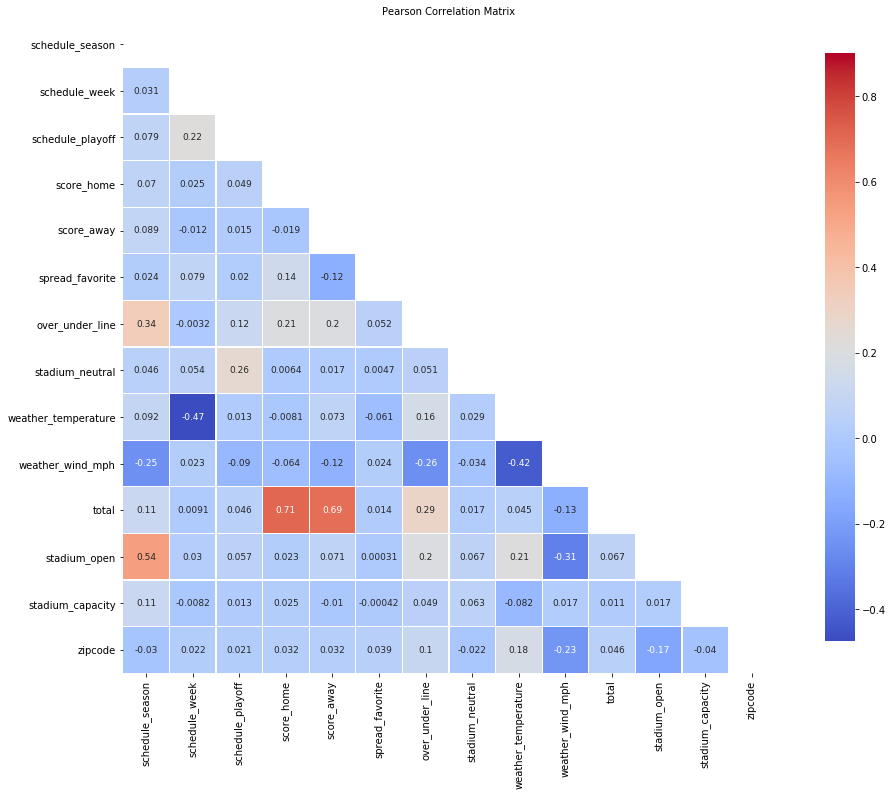

In [5]:
# Plot Correlation to Visualize Multi-Collinearity

mask = np.zeros_like(df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(df.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

## Target Variable: Over/Under Result

In [6]:
df.over_under_result.value_counts()

Under    4986
Over     4698
Name: over_under_result, dtype: int64

In [7]:
#Percentages 
print("Percent Over Outcomes")
print((df.groupby(['over_under_result']).over_under_result.count()[0]/
       df.groupby(['over_under_result']).over_under_result.count().sum()))
print("Percent Under Outcomes")
print((df.groupby(['over_under_result']).over_under_result.count()[1]/
       df.groupby(['over_under_result']).over_under_result.count().sum()))


Percent Over Outcomes
0.4851301115241636
Percent Under Outcomes
0.5148698884758365


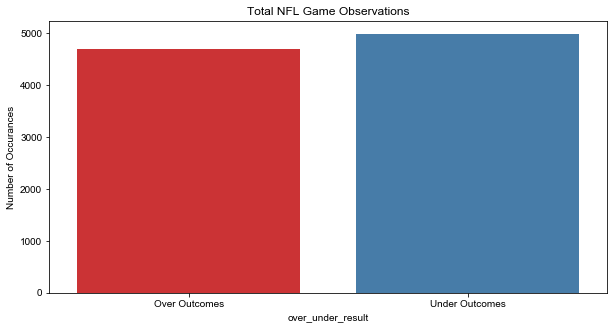

In [8]:
#Target Variable Countplot
plt.figure(figsize = (10,5))
sns.countplot(df['over_under_result'], palette="Set1")
sns.set_style("whitegrid")
plt.title('Total NFL Game Observations')
plt.ylabel('Number of Occurances')
plt.xticks(np.arange(2), ['Over Outcomes','Under Outcomes'])
plt.show()

## Independent Variable 1: Season

1979 to 2020

In [9]:
#df.schedule_season.value_counts()

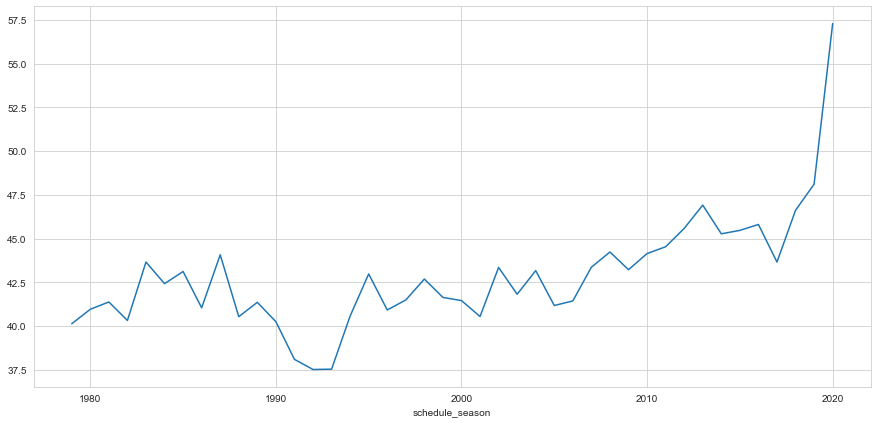

In [10]:
# Total Points seems to be slightly increasing over time

fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['schedule_season'])['total'].mean().plot(ax=ax)

In [11]:
print("Percent Over Outcomes")
print((df.groupby(['schedule_season','over_under_result']).over_under_result.count()[0]/
       df.groupby(['schedule_season','over_under_result']).over_under_result.count().sum()))

Percent Over Outcomes
0.012288310615448161


In [12]:
df.groupby(['schedule_season','over_under_result']).over_under_result.count()

schedule_season  over_under_result
1979             Over                 119
                 Under                105
1980             Over                 103
                 Under                122
1981             Over                 109
                                     ... 
2018             Under                142
2019             Over                  35
                 Under                 31
2020             Over                  18
                 Under                 10
Name: over_under_result, Length: 84, dtype: int64

## Independent Variable 2: Schedule Week

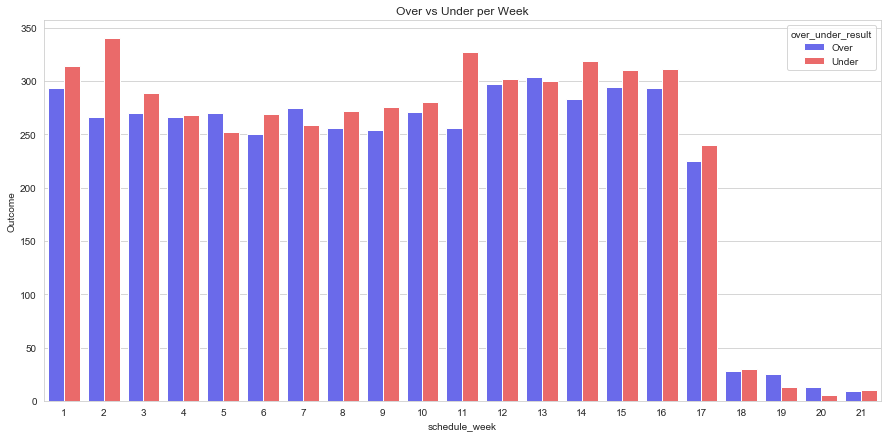

In [13]:
plt.figure(figsize = (15,7))
sns.countplot(x='schedule_week',hue="over_under_result",data=df.reset_index(),palette='seismic')
sns.set_style("darkgrid")
plt.title('Over vs Under per Week')
plt.ylabel('Outcome')
plt.show()


## Independent Variable 3: Spread

In [14]:
df.spread_favorite.value_counts()

3.0     1491
3.5      765
7.0      687
2.5      633
4.0      534
6.0      533
1.0      476
6.5      476
2.0      437
4.5      333
5.5      327
1.5      305
5.0      299
7.5      297
10.0     269
9.0      240
8.0      213
9.5      181
8.5      159
10.5     143
0.0      142
11.0     116
13.0     103
13.5     100
14.0      85
12.0      64
11.5      56
14.5      51
12.5      49
17.0      21
15.0      21
16.0      20
16.5      16
15.5      15
18.0       7
17.5       5
20.0       3
19.0       2
20.5       2
18.5       2
24.0       1
24.5       1
19.5       1
26.5       1
21.5       1
22.5       1
Name: spread_favorite, dtype: int64

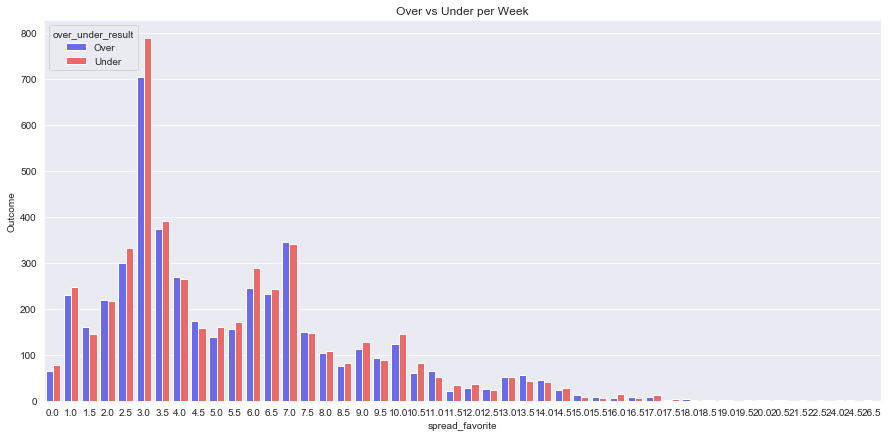

In [15]:
plt.figure(figsize = (15,7))
sns.countplot(x='spread_favorite',hue="over_under_result",data=df.reset_index(),palette='seismic')
sns.set_style("darkgrid")
plt.title('Over vs Under per Week')
plt.ylabel('Outcome')
plt.show()

Text(0.5, 0, 'Spread')

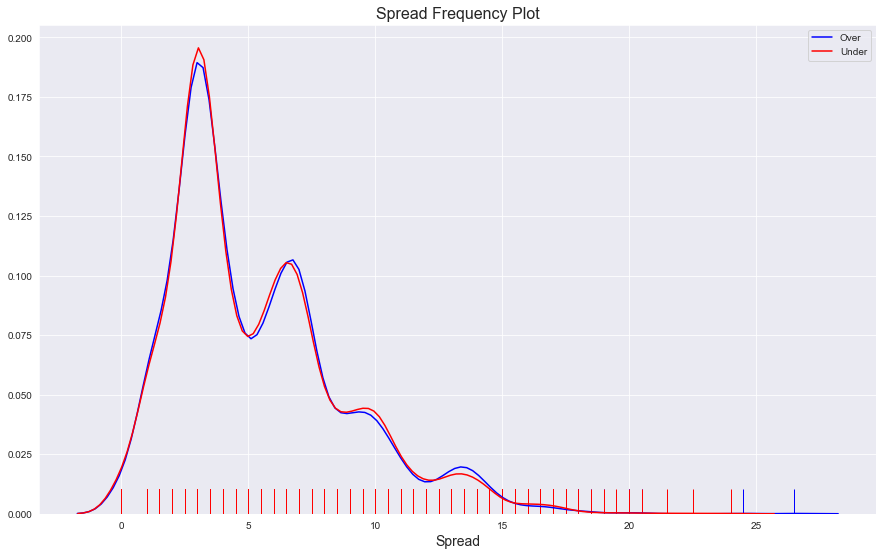

In [16]:
fig, ax = plt.subplots(figsize = (15,9));
op = sns.distplot(df[df['over_under_result']== 'Over'].spread_favorite, color='blue',hist=False, rug=True, label = 'Over')
op = sns.distplot(df[df['over_under_result']== 'Under'].spread_favorite, color='red',hist=False, rug=True, label = 'Under')
op.set_title('Spread Frequency Plot',fontsize=16)
plt.xlabel('Spread',fontsize=14)


## Independant Variable 4: Wind Mile per Hour

In [17]:
df.weather_wind_mph.describe()

count    9684.000000
mean        7.294610
std         5.711474
min         0.000000
25%         1.000000
50%         7.500000
75%        11.000000
max        40.000000
Name: weather_wind_mph, dtype: float64

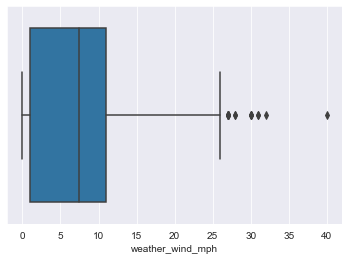

In [18]:
sns.boxplot(df.weather_wind_mph)

In [19]:
df[df['weather_wind_mph']>30]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,total,over_under_result,stadium_name,stadium_location,stadium_open,stadium_type,stadium_capacity,stadium_surface,zipcode
3512,1994-12-24,1994,17,False,New York Giants,15.0,10.0,Dallas Cowboys,DAL,3.0,36.0,False,46.0,31.0,25,Under,Giants Stadium,"East Rutherford, NJ",1976,outdoor,80242,FieldTurf,7073
7152,2008-12-28,2008,17,False,Buffalo Bills,0.0,13.0,New England Patriots,NE,5.5,34.5,False,51.0,32.0,13,Under,Ralph Wilson Stadium,"Orchard Park, NY",1973,outdoor,73967,FieldTurf,14127
7842,2011-11-13,2011,10,False,Cleveland Browns,12.0,13.0,St. Louis Rams,CLE,3.0,36.5,False,63.0,40.0,25,Under,FirstEnergy Stadium,"Cleveland, OH",1999,outdoor,68000,Grass,44114
8405,2013-11-24,2013,12,False,Cleveland Browns,11.0,27.0,Pittsburgh Steelers,CLE,2.0,39.0,False,33.0,31.0,38,Under,FirstEnergy Stadium,"Cleveland, OH",1999,outdoor,68000,Grass,44114


In [20]:
wind_groups=[]
for i in df['weather_wind_mph']:
    if (i >= 0) & (i < 7):
        wind_groups.append(0)
    elif (i >= 7)&(i < 10):
        wind_groups.append(1)
    else:
        wind_groups.append(2)
df['Wind-Group'] = wind_groups

[Text(0, 0, 'Light'), Text(0, 0, 'Mild'), Text(0, 0, 'Heavy')]

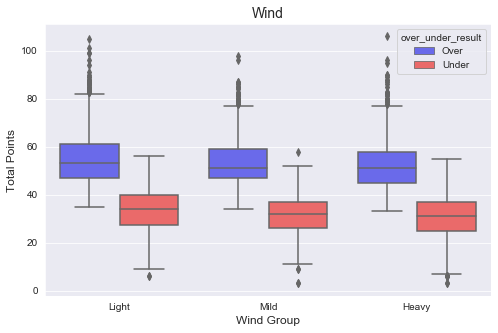

In [21]:
plt.subplots(figsize = (8,5));
mh = sns.boxplot(x = 'Wind-Group', y = 'total', hue = 'over_under_result',data = df, palette="seismic")
mh.set_title('Wind',fontsize=14)
mh.set_ylabel('Total Points',fontsize=12)
mh.set_xlabel('Wind Group',fontsize=12)
mh.set_xticklabels(['Light','Mild','Heavy'])

## Independant Variable 5: Stadium Capacity

In [22]:
df.stadium_capacity.describe()

count      9684.000000
mean      69026.580545
std        8888.589868
min       27000.000000
25%       64121.000000
50%       68756.000000
75%       76125.000000
max      100000.000000
Name: stadium_capacity, dtype: float64

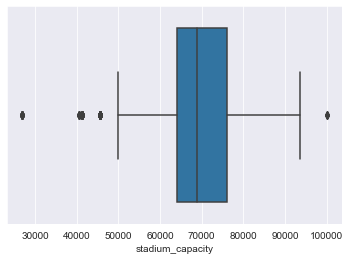

In [23]:
sns.boxplot(df.stadium_capacity)

Text(0.5, 0, 'Capacity')

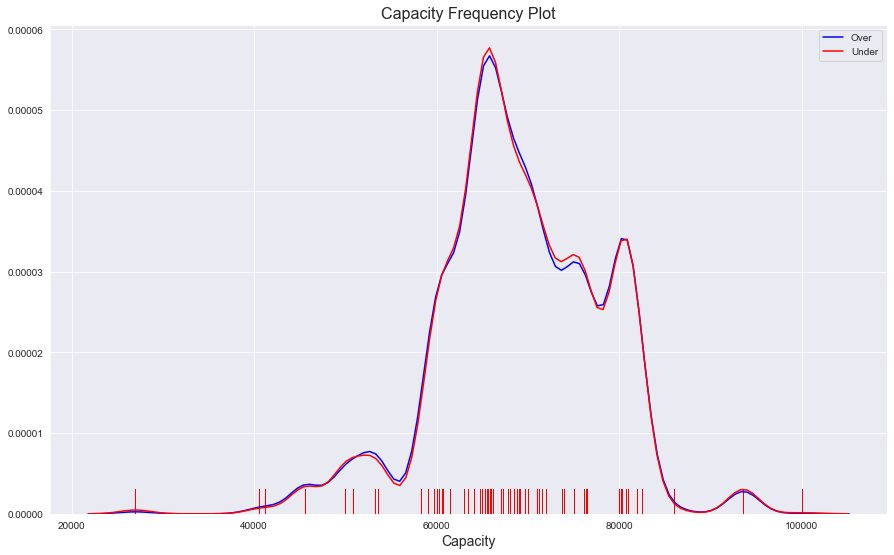

In [24]:
fig, ax = plt.subplots(figsize = (15,9));
op = sns.distplot(df[df['over_under_result']== 'Over'].stadium_capacity, color='blue',hist=False, rug=True, label = 'Over')
op = sns.distplot(df[df['over_under_result']== 'Under'].stadium_capacity, color='red',hist=False, rug=True, label = 'Under')
op.set_title('Capacity Frequency Plot',fontsize=16)
plt.xlabel('Capacity',fontsize=14)


# Feature Engineering

In [25]:
df.schedule_playoff.value_counts()

False    9565
True      119
Name: schedule_playoff, dtype: int64

In [26]:
df.drop(columns=['score_home','score_away', 'stadium_location','Wind-Group','total'],inplace=True)

df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

uint8_columns = list(df.select_dtypes('uint8').columns)

for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

In [27]:
import datetime

df['schedule_date'] = pd.to_datetime(df['schedule_date'])
df.drop('schedule_date', axis=1,inplace=True)

# Feature Selection

In [28]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

In [29]:
corrs_dict={}
for col in X.columns:
    corr=y.corr(X[col])
    corrs_dict[corr]=col

In [30]:
sorted(corrs_dict.items(),reverse=True)

[(0.02643507765088869, 'stadium_name_Cinergy Field'),
 (0.026416287574825382, 'stadium_name_New Era Field'),
 (0.023824693598373855, 'team_away_San Diego Chargers'),
 (0.02267698602796424, 'team_favorite_id_GB'),
 (0.022233434271607625, 'team_home_Los Angeles Rams'),
 (0.021686128129850147, 'team_home_Tennessee Titans'),
 (0.020461361803612396, 'stadium_name_Mile High Stadium'),
 (0.020380118175394576, 'stadium_name_Nissan Stadium'),
 (0.019866963896616848, 'team_away_Indianapolis Colts'),
 (0.019401942995838185, 'team_favorite_id_DET'),
 (0.019259995276488473, 'schedule_playoff'),
 (0.01905794388098324, 'stadium_name_Anaheim Stadium'),
 (0.018970180894961983, 'team_favorite_id_LAR'),
 (0.018115757195356234, 'team_away_Green Bay Packers'),
 (0.016021391998387598, 'team_favorite_id_DEN'),
 (0.01547820305912302, 'team_favorite_id_TEN'),
 (0.015331177015877535, 'team_home_Denver Broncos'),
 (0.015285025033512398, 'team_home_Detroit Lions'),
 (0.014664346586771577, 'team_home_New Orleans S

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9684 entries, 0 to 10211
Columns: 198 entries, schedule_season to team_favorite_id_WAS
dtypes: float64(4), int64(194)
memory usage: 15.0 MB


In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [33]:
Vif.sort_values('VIF',ascending=False)[:5]

,VIF,Features
99,inf,team_home_Houston Oilers
75,inf,stadium_name_Sun Devil Stadium
73,inf,stadium_name_Sports Authority Field at Mile High
72,inf,stadium_name_Soldier Field
71,inf,stadium_name_Seattle Kingdome
